In [494]:
from k_means_constrained import KMeansConstrained
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from shapely.geometry import Polygon, LineString, Point

## Creating the delivery Locations

In [495]:
def create_locations(x, y, n):
    loc = []

    for _ in range(n):
        loc_x = random.randint(int(x[0]), int(y[0])) + random.randint(int((x[0] - int(x[0]))*10000), int((y[0] - int(y[0]))*10000)) / 10000
        loc_y = random.randint(int(x[1]), int(y[1])) + random.randint(int((x[1] - int(x[1]))*10000), int((y[1] - int(y[1]))*10000)) / 10000
        loc.append([loc_x,loc_y])
        
    return loc

## Verify delivary locations

In [496]:
def create_polygon(points):
    pt1 = points[0]
    pt2 = points[1]
    coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
    obstacle = Polygon(coord)
    return obstacle

In [497]:
def verify_locations(delivery_loc, obstacles):
    obstacle_polygon = []
    answer = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))
    
    for loc in delivery_loc:
        flag = True
        for obs in obstacle_polygon:
            if Point([loc[0],loc[1]]).intersects(obs):
                flag = False
                break
        if flag:
            answer.append(loc)

    return answer

## Visualizing the data

In [498]:
def initial_plot(delivery_loc, obstacles):
    loc = np.array(delivery_loc)
    plt.scatter(loc[:,0], loc[:,1])
    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    plt.title("Delivery Locations")
    plt.show()

In [499]:
def clusters_plot(clusters, centroids, obstacles):
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        #try
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    plt.title("After Clustering")
    plt.show()

In [500]:
def dp_plot(clusters, centroids, dp, obstacles):
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        #try
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    plt.scatter(dp[0], dp[1], marker='+',s=200, c="red")
    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    plt.title("After DP Creation")
    plt.show()

In [501]:
def final_plot(clusters, dp, obstacles):
    colors = ['blue', 'green', 'orange', 'purple', 'brown']

    for i in clusters:
        pts = np.array(clusters[i])
        plt.scatter(pts[:,0], pts[:,1])
        #try
        points = pts[1:-1,:]
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try

        for j in range(len(pts)-1):
            pt_1 = pts[j]
            pt_2 = pts[j+1]

            plt.plot([pt_1[0], pt_2[0]], [pt_1[1], pt_2[1]], c=colors[i % len(colors)])

    plt.scatter(dp[0], dp[1], c="red", marker='X',s=200)
    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    plt.title("Final Result")
    plt.show()

## KMeans Clustering

In [502]:
def KMeans(delivery_loc, n, k):
    n_cluster = n//k if n%k == 0 else n//k + 1

    model = KMeansConstrained(n_clusters=n_cluster, size_min=1, size_max=k)
    model.fit_predict(np.array(delivery_loc))

    labels = model.labels_
    clusters = {label:[] for label in range(n_cluster)}

    for i in range(len(delivery_loc)):
        clusters[labels[i]].append(delivery_loc[i])

    return model.cluster_centers_, clusters

## Calculate DP

In [503]:
def calculate_dp(centroids):
    x = [i for i,j in centroids]
    y = [j for i,j in centroids]

    loc_x = np.mean(x)
    loc_y = np.mean(y)

    return [loc_x, loc_y]

## Traveling Salesman Problem

In [504]:
def calculate_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum((point1 - point2)**2))

In [505]:
def is_obstacle_free(line, obstacles):
    for obs in obstacles:
        if line.intersects(obs):
            return False
    return True

In [506]:
import math

def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])
    obstacle_polygons = obstacles
    target_obs = None

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle in obstacle_polygons:
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))
            if target_obs == None and len(intersections)>0:
                target_obs = obstacle

    # If no intersections found, return None
    if not intersections:
        return None

    # Choose the intersection with the smallest sum of distances to A and B
    inter_x = sum(inter.x for inter in intersections)/len(intersections)
    inter_y = sum(inter.y for inter in intersections)/len(intersections)
    nearest_inter = Point(inter_x, inter_y)

    interval = 0.01
    increment = 0.01
    limit = 1.0

    while interval < limit:
        # Check if there's a clear path along either side of the obstacle
        left_side = LineString([point_a, Point(nearest_inter.x - interval, nearest_inter.y)])
        right_side = LineString([point_a, Point(nearest_inter.x + interval, nearest_inter.y)])
        up_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y + interval)])
        down_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y - interval)])

        # check if left_side is obstacle free
        # if not left_side.intersects(target_obs):
        if is_obstacle_free(left_side, obstacle_polygons):
            left_to_B = LineString([[nearest_inter.x - interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_1 = True
            for obs in obstacle_polygons:
                if(left_to_B.intersects(obs)):
                    flag_1 = False
                    break
            if flag_1:
                return [nearest_inter.x - interval, nearest_inter.y]
        # check if right_side is obstacle free
        # if not right_side.intersects(target_obs):
        if is_obstacle_free(right_side, obstacle_polygons):
            right_to_B = LineString([[nearest_inter.x + interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_2 = True
            for obs in obstacle_polygons:
                if(right_to_B.intersects(obs)):
                    flag_2 = False
                    break
            if flag_2:
                return [nearest_inter.x + interval, nearest_inter.y]
        # check if up_side is obstacle free
        # if not up_side.intersects(target_obs):
        if is_obstacle_free(up_side, obstacle_polygons):
            up_to_B = LineString([[nearest_inter.x, nearest_inter.y + interval],[point_b[0],point_b[1]]])
            flag_3 = True
            for obs in obstacle_polygons:
                if(up_to_B.intersects(obs)):
                    flag_3 = False
                    break
            if flag_3:
                return [nearest_inter.x, nearest_inter.y + interval]
        # check if down_side is obstacle free
        # if not down_side.intersects(target_obs):
        if is_obstacle_free(down_side, obstacle_polygons):
            down_to_B = LineString([[nearest_inter.x, nearest_inter.y - interval],[point_b[0],point_b[1]]])
            flag_4 = True
            for obs in obstacle_polygons:
                if(down_to_B.intersects(obs)):
                    flag_4 = False
                    break
            if flag_4:
                return [nearest_inter.x, nearest_inter.y - interval]
        interval += increment

    return None

In [507]:
def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle in obstacles:
    if line.intersects(obstacle):
      intermediate_point = find_inter_point(point_a, point_b, obstacles)
      dist_1 = calculate_distance(point_a, intermediate_point)
      dist_2 = calculate_distance(intermediate_point, point_b)
      return dist_1 + dist_2

  return calculate_distance(point_a, point_b)

In [508]:
def create_distance_matrix(points, obstacles):
    matrix = {}
    obstacle_polygon = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))

    for src in points:
        for dest in points:
            src_point = tuple(src)
            dest_point = tuple(dest)
            distance = check_obstacle_in_line(src_point, dest_point, obstacle_polygon)
            matrix[(src_point, dest_point)] = distance
    
    return matrix

In [509]:
from itertools import permutations

def tsp_brut(cluster, dp, obstacles):
    paths = list(permutations(cluster))
    distance_matrix = create_distance_matrix(cluster, obstacles)

    # work start
    for key1,key2 in distance_matrix:
        print("Point",key1," ",key2," distance",distance_matrix[(key1, key2)])
    # work end

    cost = []
    # add dp at the start and end
    for i in range(len(paths)):
        paths[i] = list(paths[i])
        paths[i].append(dp)
        paths[i].insert(0, dp)

        # Calculate distance
        points = paths[i]
        sum = 0

        for j in range(len(points)-1):
            sum += calculate_distance(points[j], points[j+1])
        cost.append(sum)

    idx = np.argmin(cost)
    return paths[idx]

## Main

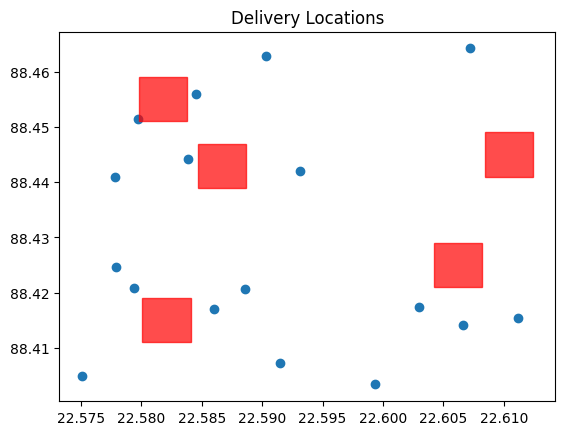

In [510]:
#no of delivery locations and drone capacity
n = 20
k = 5

# creating the boundary
x = [22.5726, 88.4010]
y = [22.6141, 88.4654]
delivery_loc = create_locations(x, y, n)

# obstacles
obstacles = {
    0 : [[22.5801, 88.4110],[22.5841, 88.4190]],
    1 : [[22.6042, 88.4210],[22.6082, 88.4290]],
    2 : [[22.6084, 88.4410],[22.6124, 88.4490]],
    3 : [[22.5798, 88.4510],[22.5838, 88.4590]],
    4 : [[22.5847, 88.4390],[22.5887, 88.4470]],
}

delivery_loc = verify_locations(delivery_loc, obstacles)

# Visualize the data
initial_plot(delivery_loc, obstacles)

{0: [[22.5839, 88.4442], [22.5797, 88.4515], [22.5845, 88.4559], [22.5778, 88.441], [22.5931, 88.4421]], 1: [[22.6066, 88.4142], [22.5915, 88.4073], [22.6112, 88.4154], [22.603, 88.4175], [22.5993, 88.4034]], 2: [[22.5751, 88.405], [22.5794, 88.4208], [22.5779, 88.4247], [22.586, 88.417], [22.5886, 88.4207]], 3: [[22.6072, 88.4642], [22.5903, 88.4628]]}


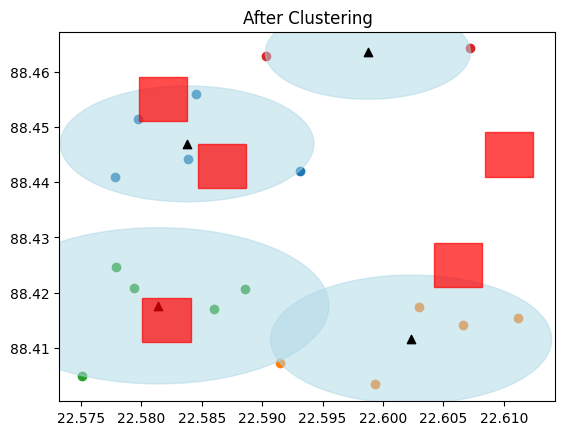

In [511]:
# Cluster the data and get the labels and centroids
centroids, clusters = KMeans(delivery_loc, n, k)

print(clusters)

# Visualize the data
clusters_plot(clusters, centroids, obstacles)

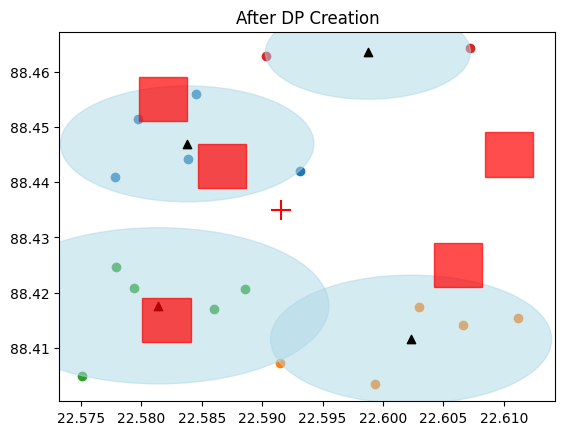

In [512]:
# Calculate DP
DP = calculate_dp(centroids)

# Visualize the data
dp_plot(clusters, centroids, DP, obstacles)

In [513]:
# Shortest path calculation in each cluster
for i in clusters:
    clusters[i] = tsp_brut(clusters[i], DP, obstacles)


Point (22.5839, 88.4442)   (22.5839, 88.4442)  distance 0.0
Point (22.5839, 88.4442)   (22.5797, 88.4515)  distance 0.025453476112129766
Point (22.5839, 88.4442)   (22.5845, 88.4559)  distance 0.01171537451386461
Point (22.5839, 88.4442)   (22.5778, 88.441)  distance 0.00688839603971434
Point (22.5839, 88.4442)   (22.5931, 88.4421)  distance 0.04195713347780129
Point (22.5797, 88.4515)   (22.5839, 88.4442)  distance 0.025453476112129766
Point (22.5797, 88.4515)   (22.5797, 88.4515)  distance 0.0
Point (22.5797, 88.4515)   (22.5845, 88.4559)  distance 0.040833182020219294
Point (22.5797, 88.4515)   (22.5778, 88.441)  distance 0.010670520137268652
Point (22.5797, 88.4515)   (22.5931, 88.4421)  distance 0.039576619963898385
Point (22.5845, 88.4559)   (22.5839, 88.4442)  distance 0.01171537451386461
Point (22.5845, 88.4559)   (22.5797, 88.4515)  distance 0.040833182020219294
Point (22.5845, 88.4559)   (22.5845, 88.4559)  distance 0.0
Point (22.5845, 88.4559)   (22.5778, 88.441)  distance 0

In [514]:
for i in clusters:
    print("Path",i,":")
    for j in clusters[i]:
        print(j,"->",end=" ")
    print("End")

Path 0 :
[22.5915675, 88.43491] -> [22.5839, 88.4442] -> [22.5778, 88.441] -> [22.5797, 88.4515] -> [22.5845, 88.4559] -> [22.5931, 88.4421] -> [22.5915675, 88.43491] -> End
Path 1 :
[22.5915675, 88.43491] -> [22.603, 88.4175] -> [22.6112, 88.4154] -> [22.6066, 88.4142] -> [22.5993, 88.4034] -> [22.5915, 88.4073] -> [22.5915675, 88.43491] -> End
Path 2 :
[22.5915675, 88.43491] -> [22.5886, 88.4207] -> [22.586, 88.417] -> [22.5751, 88.405] -> [22.5794, 88.4208] -> [22.5779, 88.4247] -> [22.5915675, 88.43491] -> End
Path 3 :
[22.5915675, 88.43491] -> [22.5903, 88.4628] -> [22.6072, 88.4642] -> [22.5915675, 88.43491] -> End


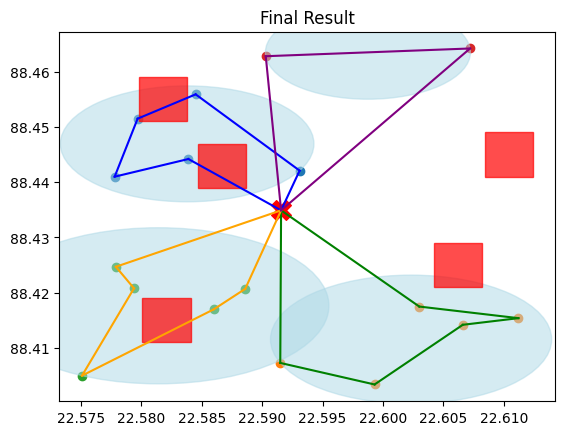

In [515]:
# Final Visualization
final_plot(clusters, DP, obstacles)

## Calculate Total DIstance

In [516]:
def total_distance(clusters):
    total = 0
    for i in clusters:
        pts = clusters[i]
        for j in range(len(pts)-1):
            total += calculate_distance(pts[j], pts[j+1])
    
    return total

*Total distance in manhattan cluster*

In [517]:
dist = total_distance(clusters)
print("Distance using manhattan cluster :",dist)

Distance using manhattan cluster : 0.29408163223142286


## Hold

In [518]:
from itertools import permutations

def tsp_brut(cluster, dp):
    path = list(permutations(cluster))
    cost = []
    # add dp at the start and end
    for i in range(len(path)):
        path[i] = list(path[i])
        path[i].append(dp)
        path[i].insert(0, dp)

        # Calculate distance
        points = path[i]
        sum = 0

        for j in range(len(points)-1):
            sum += calculate_distance(points[j], points[j+1])
        cost.append(sum)

    idx = np.argmin(cost)
    return path[idx]

In [519]:
lst = [1,2,3,4,5,6]
paths = list(permutations(lst))
print(list(paths[0]))

[1, 2, 3, 4, 5, 6]
